## Breaking and Nonlinear Trends

### Example 6.1

In [1]:
# 导入需要的第三方包
import numpy as np
import pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import statsmodels
from statsmodels.tsa.ar_model import AutoReg
import statsmodels.tsa.api as smt
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from math import log

读入数据并作图查看

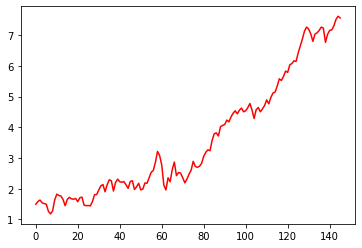

In [5]:
oil=pd.read_csv("D:/anaconda3/envs/python36/TimeSeries/CH6/oil.csv")['price']
plt.plot(oil,'r')
plt.show()

Perron测试程序中的一个关键假设是，假定中断日期Tcb是已知的，或者由外部确定了导致趋势中断的冲击。 佩隆研究的是20世纪的美国经济，他假设发生了两次外部经济冲击，即1929年的股市大崩溃和1973年的油价冲击。
图6.3表明：在1871年至2016年期间，标普500指数每年都以$x_t^c$的形式出现突破趋势，并叠加有$T_b^c=59$ （1929），这清楚地表明了带断点的TS过程可以充分模拟该指数的演变。

[[ 0.30791207]
 [-0.19232174]
 [ 0.00543688]
 [ 0.01143694]
 [ 0.38249072]
 [-0.12713068]
 [ 0.88411107]]


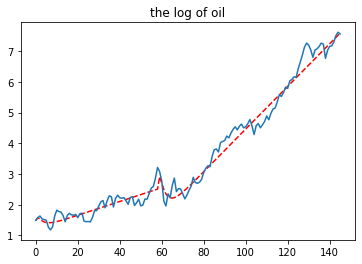

In [6]:
Tbc_61=59 #间断点的位置已知
T=len(oil)
tao_c=Tbc_61/T
#用最小二乘法估计趋势平稳的时间序列
#以下函数估计出的参数依次为beta0,beta1,phip，phi_{p-1},...,phi2,phi1
def DU(x,Tbc):
    if x<=Tbc:
        return 0
    else:
        return 1

def DT(x,Tbc):
    if x<=Tbc:
        return 0
    else:
        return x-Tbc

def Dummy(x,Tbc):
    if x==Tbc:
        return 1
    else:
        return 0
   
#以下函数估计出的参数依次为beta0,beta1,phip，phi_{p-1},...,phi2,phi1
def estimate_TD(sample,p):  
    matrix_x=np.zeros((len(sample)-p,p+2))  
    array=sample.reshape(len(sample))  #array是样本全体
    j=0
    for i in range(0,len(sample)-p):
        matrix_x[i,0:p+2]=np.hstack((np.array([1,p+i+1]),array[j:j+p]))
        j+=1  
    #在原有AR的OLS方法基础上加上beta0+beta1*t这一项
    matrix_y=np.array(array[p:len(sample)])
    matrix_y=matrix_y.reshape(len(sample)-p,1)
    #所有系数的表达式：A=(X^TX)^-1 X^T Y
    coef=np.dot(np.dot(np.linalg.inv(np.dot(matrix_x.T,matrix_x)),matrix_x.T),matrix_y)
    return coef


def estimate_Break(sample,p,Tbc):  
    matrix_x=np.zeros((len(sample)-p,p+5))  
    array=sample.reshape(len(sample))  #array是样本全体
    j=0
    for i in range(0,len(sample)-p):
        matrix_x[i,0:p+5]=np.hstack((np.array([1,DU(p+i+1,Tbc),p+i+1,DT(p+i+1,Tbc),Dummy(p+i+1,Tbc)]),array[j:j+p]))
        j+=1  
    #在原有AR的OLS方法基础上加上beta0+beta1*t这一项
    matrix_y=np.array(array[p:len(sample)])
    matrix_y=matrix_y.reshape(len(sample)-p,1)
    #所有系数的表达式：A=(X^TX)^-1 X^T Y
    coef=np.dot(np.dot(np.linalg.inv(np.dot(matrix_x.T,matrix_x)),matrix_x.T),matrix_y)
    return coef
oil1=oil[0:59]
oil2=oil[59:len(oil)]
para=estimate_Break(np.array(oil),2,59)
#para2=estimate_TD(np.array(oil2),2)
#print(para1)
print(para)

b0=para[0][0]
b01=para[1][0]
b1=para[2][0]
b11=para[3][0]
d=para[4][0]
phi2=para[5][0]
phi1=para[6][0]
trend=[0]*2
trend[0]=oil[0]
trend[1]=oil[1]
for i in range(2,len(oil)):
    trend.append(i*b1+b0+b01*DU(i,59)+b11*DT(i,59)+d*Dummy(i,59)+phi1*trend[i-1]+phi2*trend[i-2])
plt.plot(trend,'r--')
plt.plot(oil)
plt.title('the log of oil')
plt.show()

下面为检验参数估计的合理性，进行显著性检验。


In [3]:
from math import sqrt

def getST(series,Phi):
    T=len(series)
    ST=0
    for i in range(1,T):
        ST+=(series[i]-Phi*series[i-1])**2
    return ST/(T-1)

def getSIG(series,Phi):
    T=len(series)
    ST=getST(series,Phi)
    sum3=0
    for i in range(0,T):
        sum3+=series[i]**2
    SIGMA=sqrt(ST/sum3)
    return SIGMA

def getT(series,Phi):
    SIGMA=getSIG(series,Phi)
    t_test=(Phi-1)/SIGMA
    return t_test

print(getT(oil,0.757))

-11.508091221993094


对应的t统计量计算为-11.5，而1%显著性水平对应的数值为$\tau^C=\frac{T_b^c}{T}=0.4$，因此可以认定该例中数据可以使用带断点的TS拟合。

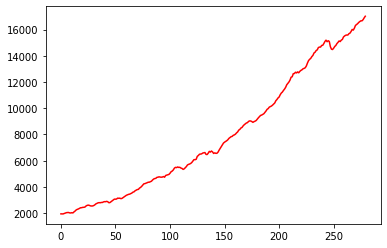

In [9]:
GNP=pd.read_csv("D:/anaconda3/envs/python36/TimeSeries/CH6/GNP.csv")['gnp']
plt.plot(GNP,'r')
plt.show()
# 间断点位置
Tbc_612=105

此处断点前趋势增长率为每季度1.0％，而断点后趋势增长率降至0.7％。

用和估计原油同样的方法可以对GNP曲线进行带断点的模型参数估计。

In [10]:
def estimate_A(sample,p,Tbc):  
    matrix_x=np.zeros((len(sample)-p,p+3))  
    array=sample.reshape(len(sample))  #array是样本全体
    j=0
    for i in range(0,len(sample)-p):
        matrix_x[i,0:p+3]=np.hstack((np.array([1,DU(p+i+1,Tbc),Dummy(p+i+1,Tbc)]),array[j:j+p]))
        j+=1  
    matrix_y=np.array(array[p:len(sample)])
    matrix_y=matrix_y.reshape(len(sample)-p,1)
    coef=np.dot(np.dot(np.linalg.inv(np.dot(matrix_x.T,matrix_x)),matrix_x.T),matrix_y)
    return coef
para_2=estimate_A(np.array(GNP),2,105)
print(estimate_A(np.array(GNP),2,105))

[[16.03760181]
 [ 8.34871689]
 [80.98397489]
 [-0.33097008]
 [ 1.33284211]]


最终得到的结果：

$\Delta x_t=-0.034 DU_t^c+\epsilon_t$

$\epsilon_t=0.350\epsilon_{t-1}+a_t$

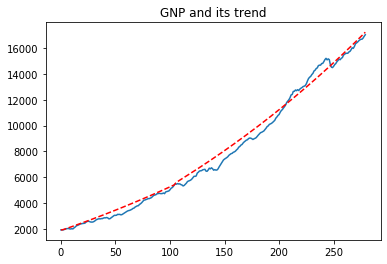

In [11]:
p1=para_2[0][0]
p2=para_2[1][0]
p3=para_2[2][0]
p4=para_2[3][0]
p5=para_2[4][0]
trend1=[0]*2
trend1[0]=GNP[0]
trend1[1]=GNP[1]
for i in range(2,len(GNP)):
    trend1.append(p1+p2*DU(i,105)+p3*Dummy(i,105)+p5*trend1[i-1]+p4*trend1[i-2])
plt.plot(GNP)
plt.plot(trend1,'r--')
plt.title('GNP and its trend')
plt.show()

### Example 6.2

选择SP 500指数的断点的最小单位根方法确实选择了1929年，它的DF统计量为25.11，边际显着性水平为0.06。
 
如果最大化中断参数的显著性，同样也会选择1929年。

In [12]:
#由自变量Tbc返回误差平方和的函数
def optim_for_62(sample,p,Tbc):  
    matrix_x=np.zeros((len(sample)-p,p+3))  
    array=sample.reshape(len(sample))  #array是样本全体
    j=0
    for i in range(0,len(sample)-p):
        matrix_x[i,0:p+3]=np.hstack((np.array([1,DU(p+i+1,Tbc),Dummy(p+i+1,Tbc)]),array[j:j+p]))
        j+=1  
    matrix_y=np.array(array[p:len(sample)])
    matrix_y=matrix_y.reshape(len(sample)-p,1)
    coef=np.dot(np.dot(np.linalg.inv(np.dot(matrix_x.T,matrix_x)),matrix_x.T),matrix_y)
    p1=para_2[0][0]
    p2=para_2[1][0]
    p3=para_2[2][0]
    p4=para_2[3][0]
    p5=para_2[4][0]
    Residual=0
    trend1=[0]*2
    trend1[0]=sample[0]
    trend1[1]=sample[1]
    for i in range(2,len(sample)):
        trend1.append(p1+p2*DU(i,Tbc)+p3*Dummy(i,Tbc)+p5*trend1[i-1]+p4*trend1[i-2])
    for i in range(len(sample)):
        Residual+=(trend1[i]-sample[i])**2
    return Residual

#print(optim_for_62(np.array(GNP),2,136))
#print(optim_for_62(np.array(GNP),2,104))
#print(optim_for_62(np.array(GNP),2,10))
optims=[]
for j in range(3,len(GNP)-1):
    optims.append(optim_for_62(np.array(GNP),2,j))
def findmin(arr):
    small=arr[0]
    small_index=0
    for i in range(1,len(arr)):
        if arr[i]<small:
            small=arr[i]
            small_index=i
    return small_index
print(optims)

[997676505.5528852, 977801180.0575576, 958197365.5775433, 938861837.2095954, 919788520.9828293, 900973420.1597862, 882412153.38496, 864108032.2810392, 846063276.8916205, 828274580.4811928, 810753986.945683, 793496011.3790627, 776498510.4099281, 759751784.7071929, 743252132.234372, 726998770.0489593, 710988506.6897272, 695213620.1858741, 679674700.9234724, 664368460.2437577, 649297321.3459421, 634466066.5790297, 619865112.3128815, 605486695.1647567, 591323516.004794, 577373319.653049, 563640949.1061308, 550128893.0967854, 536840724.133605, 523778206.22205144, 510940405.1516885, 498319326.2838833, 485910752.6542731, 473709183.2869718, 461710834.08481354, 449918604.8398087, 438329135.8599435, 426946286.0568945, 415763942.84308004, 404777495.51331997, 393987609.07779604, 383384138.535894, 372966401.1794732, 362749909.12953436, 352739371.33302546, 342931964.4903597, 333323198.3786757, 323910217.83119005, 314681017.0608398, 305638604.1208399, 296785849.6763748, 288109992.1552133, 279612245.3

### Example 6.3

在Example 6.1中，我们用了具有1929年水平和趋势变化的带断点模型拟合了SP 500指数。

这里，形式为（6.18）的等效LSTR模型可以拟合AR（2）过程的误差：

In [13]:
from math import exp
def LSTR(gamma,m,t,sample):
    return 1/(1+exp(-gamma*(t-m*len(sample))))
#最小二乘法估计
def estimate_63(sample,p):  
    g=0.685
    m=0.507
    matrix_x=np.zeros((len(sample)-p,p+4))  
    array=sample.reshape(len(sample))  #array是样本全体
    j=0
    for i in range(0,len(sample)-p):
        matrix_x[i,0:p+4]=np.hstack((np.array([1,p+i+1,LSTR(g,m,p+i+1,sample),(p+i+1)*LSTR(g,m,p+i+1,sample)]),array[j:j+p]))
        j+=1  
    matrix_y=np.array(array[p:len(sample)])
    matrix_y=matrix_y.reshape(len(sample)-p,1)
    coef=np.dot(np.dot(np.linalg.inv(np.dot(matrix_x.T,matrix_x)),matrix_x.T),matrix_y)
    return coef
para=estimate_63(np.array(oil),2)


In [14]:
phi1=para[-1][0]
phi2=para[-2][0]
k=1-phi1-phi2
beta0=para[0][0]/k
beta1=para[1][0]/k
gamma0=para[2][0]/k
gamma1=para[3][0]/k
print((phi1,phi2,beta0,beta1,gamma0,gamma1))

(0.918081093188958, -0.1729359473036981, 1.3779590887770319, 0.01755863350633722, -3.6598856347095094, 0.051541177344668905)


即拟合所得的模型是：

$x_t=1.38+0.02t-3.78S_t(0.69,0.5)+0.05tS_t(0.69,0.5)+e_t$

$e_t=0.922e_{t-1}-0.168e_{t-2}+a_t$

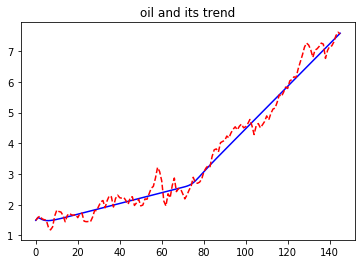

In [16]:
g=0.685
m=0.507
es1=[0]*2
es1[0]=oil[0]
es1[1]=oil[1]
for i in range(2,len(oil)):
    es1.append(para[0][0]+para[1][0]*i+para[2][0]*LSTR(g,m,i,oil)+para[3][0]*i*LSTR(g,m,i,oil)+para[-1][0]*es1[i-1]+para[-2][0]*es1[i-2])
plt.plot(es1,'b')
plt.plot(oil,'r--')
plt.title('oil and its trend')
plt.show()

该模型意味着在过渡期间截距从1.28降低到22.61，而趋势增长从每年2.0％增加到每年7.1％。 
平滑过渡的中点估计为1951年，并且$\gamma=0.685$表明，过渡速度相当快。 从图6.6所示的平稳过渡趋势可以看出，过渡大约需要6年才能完成，并且比1929年的“大崩盘”晚了二十年。

下面是n=3分量傅里叶拟合，误差项同样服从AR（2）过程。

In [17]:
from math import sin,cos,pi
def estimate_fourier(sample,p):  
    g=0.685
    m=0.507
    matrix_x=np.zeros((len(sample)-p,p+8))  
    array=sample.reshape(len(sample))  #array是样本全体
    j=0
    for i in range(0,len(sample)-p):
        matrix_x[i,0:p+8]=np.hstack((np.array([1,p+i+1,sin(2*pi*1*(p+i+1)/len(sample)),
                                               sin(2*pi*2*(p+i+1)/len(sample)),
                                               sin(2*pi*3*(p+i+1)/len(sample)),
                                               cos(2*pi*1*(p+i+1)/len(sample)),
                                               cos(2*pi*2*(p+i+1)/len(sample)),
                                               cos(2*pi*3*(p+i+1)/len(sample)),
                                               ]),array[j:j+p]))
        j+=1  
    matrix_y=np.array(array[p:len(sample)])
    matrix_y=matrix_y.reshape(len(sample)-p,1)
    coef=np.dot(np.dot(np.linalg.inv(np.dot(matrix_x.T,matrix_x)),matrix_x.T),matrix_y)
    return coef
para=estimate_fourier(np.array(oil),0)

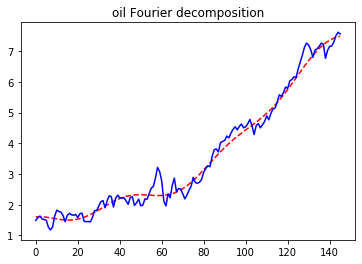

In [19]:
es2=[]
for i in range(0,len(oil)):
    es2.append(para[0][0]+para[1][0]*i+para[2][0]*sin(2*pi*1*i/len(oil))
              +para[3][0]*sin(2*pi*2*i/len(oil))+para[4][0]*sin(2*pi*3*i/len(oil))
              +para[5][0]*cos(2*pi*1*i/len(oil))+para[6][0]*cos(2*pi*2*i/len(oil))
              +para[7][0]*cos(2*pi*3*i/len(oil)))
plt.plot(es2,'r--')
plt.plot(oil,'b')
plt.title('oil Fourier decomposition')
plt.show()


### Example 6.4

使用示例6.3中拟合的LSTR模型的残差计算的DF单位根检验，误差尽管不符合AR（2）过程，但其值为24.46。 根据Leybourne等人的表1， 
（1998年）这在10％的水平上几乎是显着的，并且模型的残差通过AR（4）过程很好地拟合，两对复根分别为0.6860±23i和-0.20±0.57i。 
因此，可以大致确定，股票价格应该合理地建模为确定性的非线性趋势和平稳噪声的总和，尽管正如我们所看到的，这种转变发生在趋势的“大崩溃”之后约20年。 符合Example 6.1。

In [40]:
g=0.685
m=0.507
error=[0]*len(oil)
for i in range(0,2):
    error[i]=oil[i]-1.377-0.017*(i)+3.659*LSTR(g,m,i,oil)-0.051*(i)*LSTR(g,m,i,oil)
for i in range(2,len(error)):
    error[i]=0.918*error[i-1]-0.172*error[i-2]
print(getT(error,0.918))

-3.0621565818535568


由于T统计量大于10%置信区间对应的临界值，因此不能否定误差有单位根的原假设。